In [20]:
%reset
%matplotlib inline

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne import create_info
import pickle
import os
from auxiliary import AuxFuncs

## Import epochs

In [22]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
import_type = "5Electorodes_plainEEGLAB"
trial_exclution_str = "_excOulierTrials-3.5" #"_excOulierTrials-2.5"

In [23]:
import_path = f'{epochs_dir}\\{import_type}{trial_exclution_str}.pkl'
aux = AuxFuncs(import_path)

allEpochs_perCond = aux.allEpochs_condIdDict
allEvents_df = aux.allEvents_df
c = aux.config
times = c['times']
time0_i = c['time0_i']

fig_output_dir = f"{c['outputs_dir_path']}/erps"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

## Plot thickens

In [24]:
def applyDesign(ax,title='',y_lims=[-4,4]):
    fig.patch.set_facecolor('xkcd:white')
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper right',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel(' uV', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Time (ms)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim([-100,450])
    ax.set_ylim(y_lims)
    ax.text(-0.02, y_lims[1], 'stimulus', rotation=90, va='center', fontsize = 13)

colors_wngt = plt.cm.Blues([250,230,210,190,170,150,130,110,90])
colors_N2 = plt.cm.autumn_r([150,140,130,120,110,100,80,60,30])
colors_N3 = plt.cm.Greens([250,230,210,190,170,150,130,110,90])
colors_REM = plt.cm.Reds([250,230,210,190,170,150,130,110,90])
colors_allShadesPerVg = [colors_wngt,colors_N2,colors_N3,colors_REM]
colors_onePerVg = [colors_wngt[2],colors_N2[2],colors_N3[2],colors_REM[2]]
titles_onePerVg = ['Awake','N2','N3','REM']

In [25]:
def plot_erps_with_std(varNameForMean, varNameForStd,constraints,ax, colors,labels,varsForMean=None,varsForStd=None, linestyle='-'):
    if varsForMean is None: varsForMean =  allEvents_df[varNameForMean].unique()
    for meanVar_i,meanVar in enumerate(varsForMean):
        if varNameForStd == 'Cond_id':
            curr_constraints = constraints.copy()
            curr_constraints[varNameForMean] = meanVar
            conds_df, evoked_mat = aux.getEvokedPerCondAndElectd(curr_constraints,allEvents_df,allEpochs_perCond,times,outputType='array')
            evokedPerStdVar = np.nanmean(evoked_mat,axis=1) # mean over electrodes
            erp_trialsNum = conds_df['SamplesCount'].sum()
        else:
            if varsForStd is None: varsForStd =  allEvents_df[varNameForStd].unique()
            evokedPerStdVar = np.zeros((len(varsForStd), len(times)))
            erp_trialsNum=0
            for stdVar_i, stdVar in enumerate(varsForStd):
                curr_constraints = constraints.copy()
                curr_constraints[varNameForStd] = stdVar
                curr_constraints[varNameForMean] = meanVar

                conds_df, evoked_mat = aux.getEvokedPerCondAndElectd(curr_constraints,allEvents_df, allEpochs_perCond,times,outputType='array')
                evokedPerStdVar[stdVar_i,:] = np.nanmean(evoked_mat,axis=(0,1))
                erp_trialsNum += conds_df['SamplesCount'].sum()

        curr_meanEvoked = np.mean(evokedPerStdVar,axis=0)
        curr_stdEvoked = np.std(evokedPerStdVar,axis=0)
        ax.fill_between(times,curr_meanEvoked+curr_stdEvoked,curr_meanEvoked-curr_stdEvoked, color=colors[meanVar_i],alpha=0.1,label ="_nolegend_")
        label = f"{labels[meanVar_i]}, n={erp_trialsNum}"
        ax.plot(times,curr_meanEvoked, color=colors[meanVar_i],label=label,linestyle=linestyle)
    return ax

In [26]:
def plot_erps(varNameForMean, constraints,ax, colors,labels):
    varForMean =  allEvents_df[varNameForMean].unique()
    for vg_i,vg in enumerate(varForMean):
        curr_constraints = constraints.copy()
        curr_constraints[varNameForMean] = vg

        conds_df, evoked_mat = aux.getEvokedPerCondAndElectd(curr_constraints,allEvents_df,allEpochs_perCond,times,outputType='array')
        curr_meanEvoked = np.nanmean(evoked_mat,axis=(0,1))
        ax.plot(times,curr_meanEvoked,color=colors[vg_i],label=labels[vg_i])
    return ax

Only in "Tone" condition. Each graph contatins ERP mean for each vigi-state

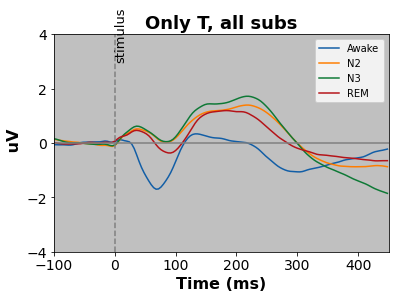

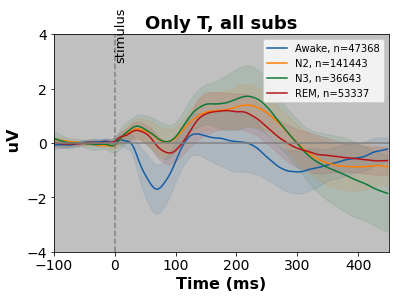

In [27]:
fig, ax = plt.subplots()
plot_erps('Vigilance', {'TOA_cond':'T'}, ax,colors_onePerVg,titles_onePerVg)
plot_title = 'Only T, all subs'
applyDesign(ax,plot_title)
plt.ioff()
# plt.show()

fig, ax = plt.subplots()
plot_erps_with_std('Vigilance','Subject', {'TOA_cond':'T'}, ax,colors_onePerVg,titles_onePerVg)
plot_title = 'Only T, all subs'
applyDesign(ax,plot_title)
plt.ioff()
plt.savefig(f'{fig_output_dir}/T_allSubs_5CentElect.png')
# plt.show()

## Per sub, Only T and only O

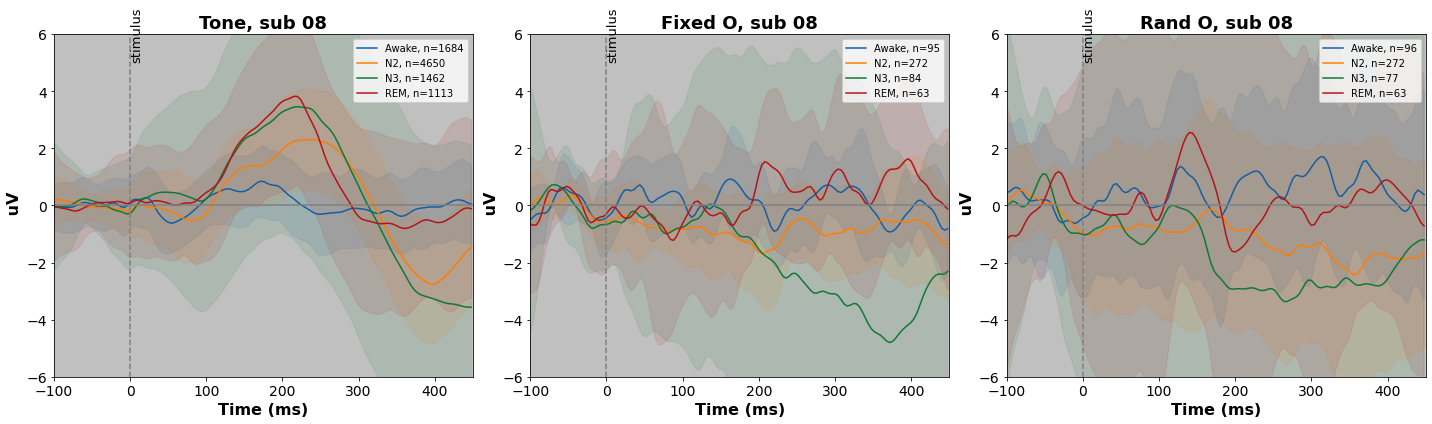

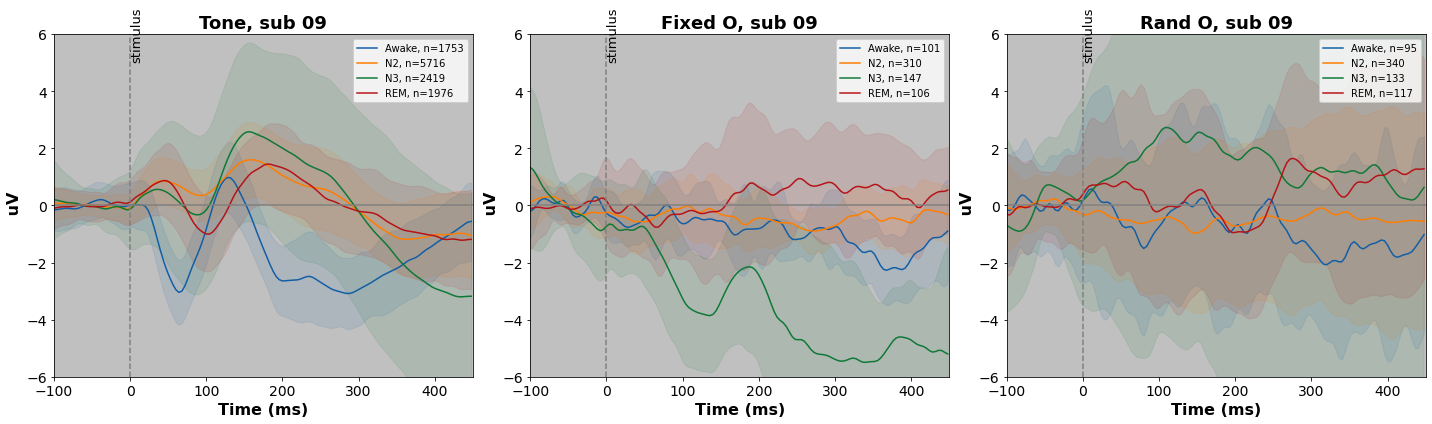

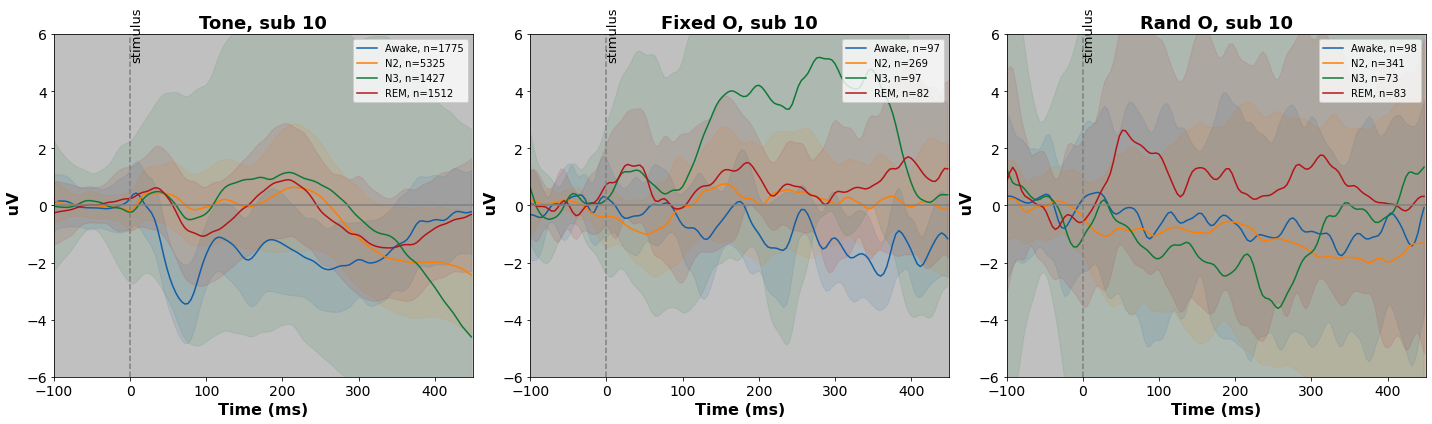

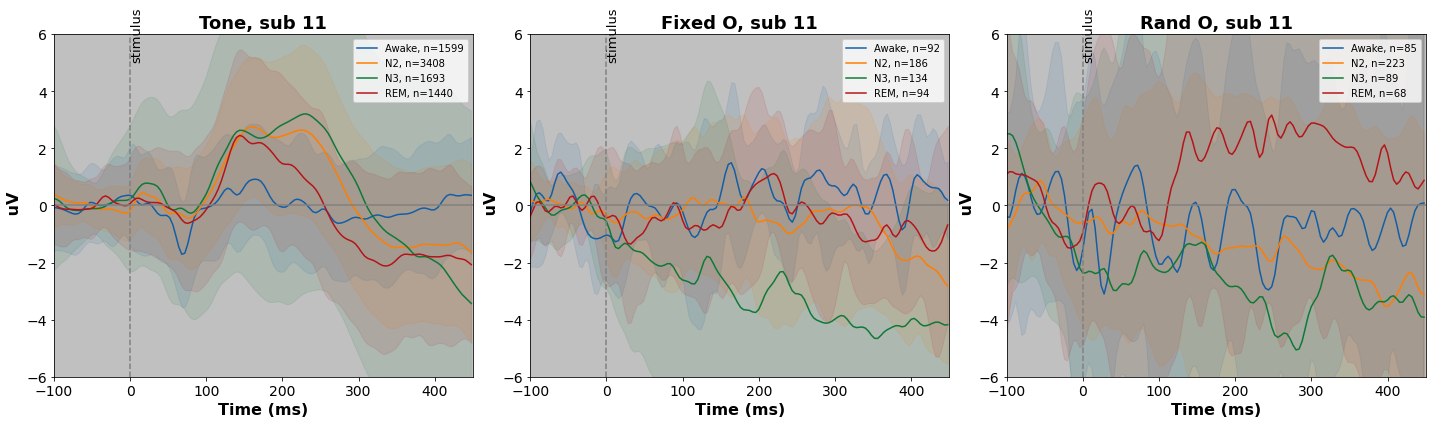

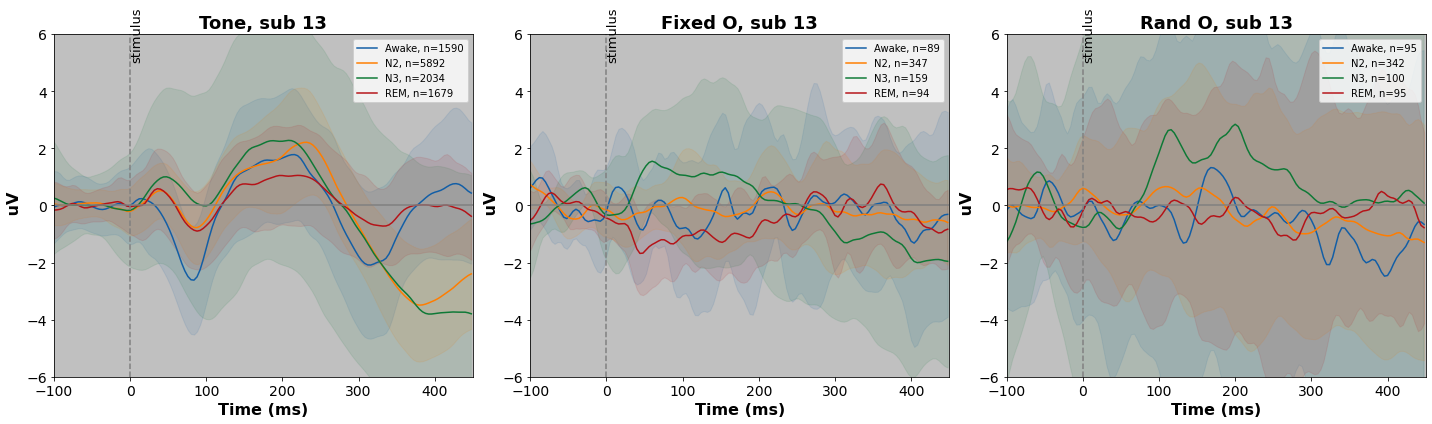

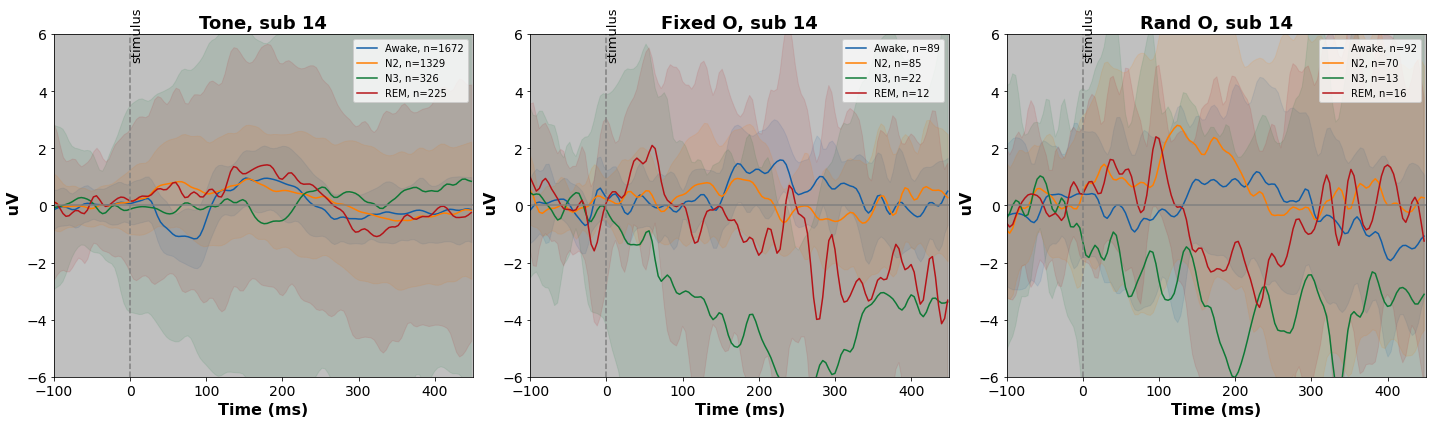

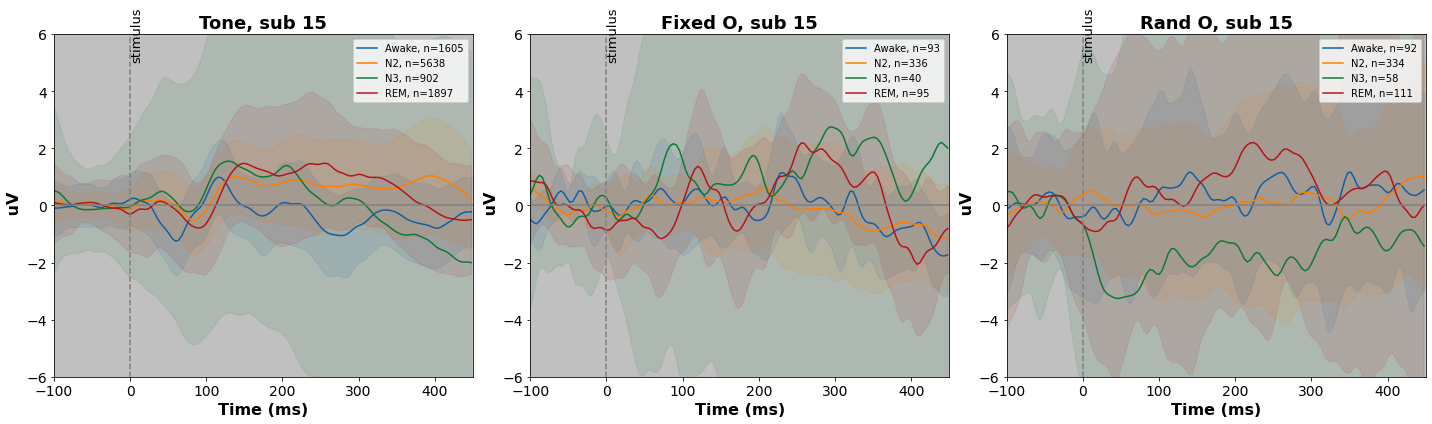

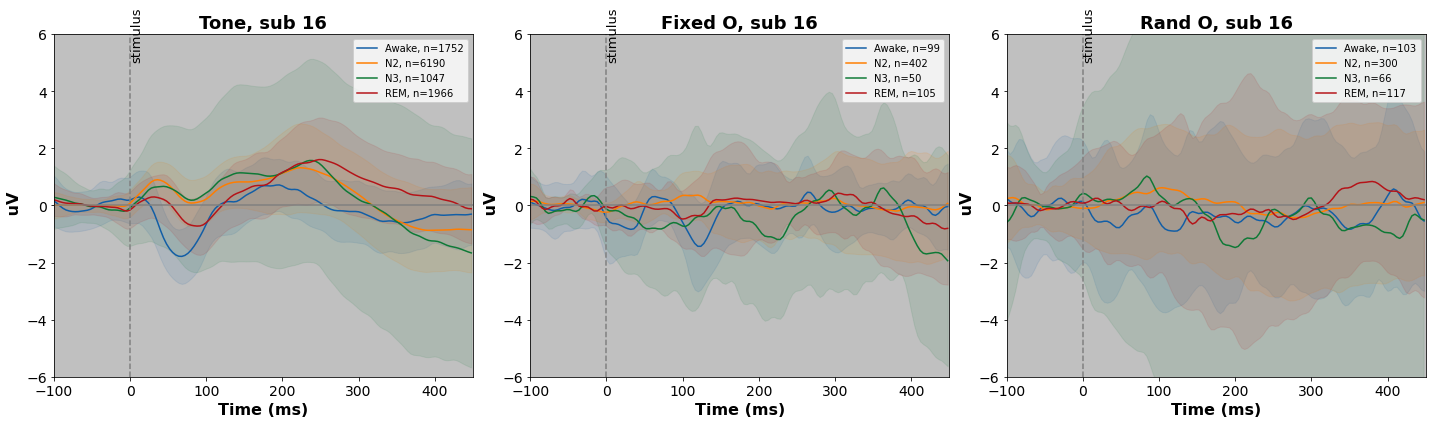

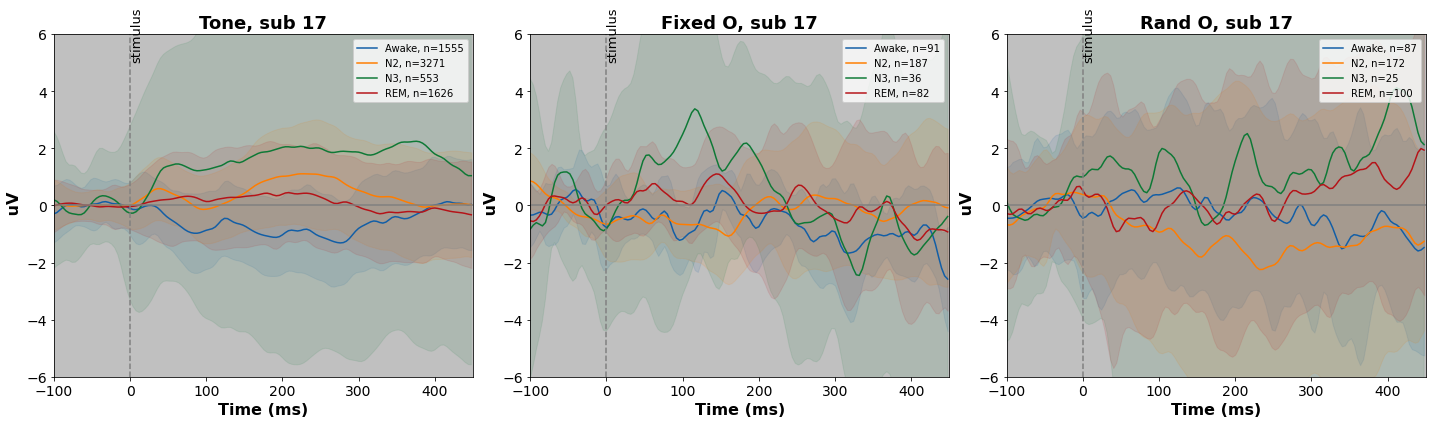

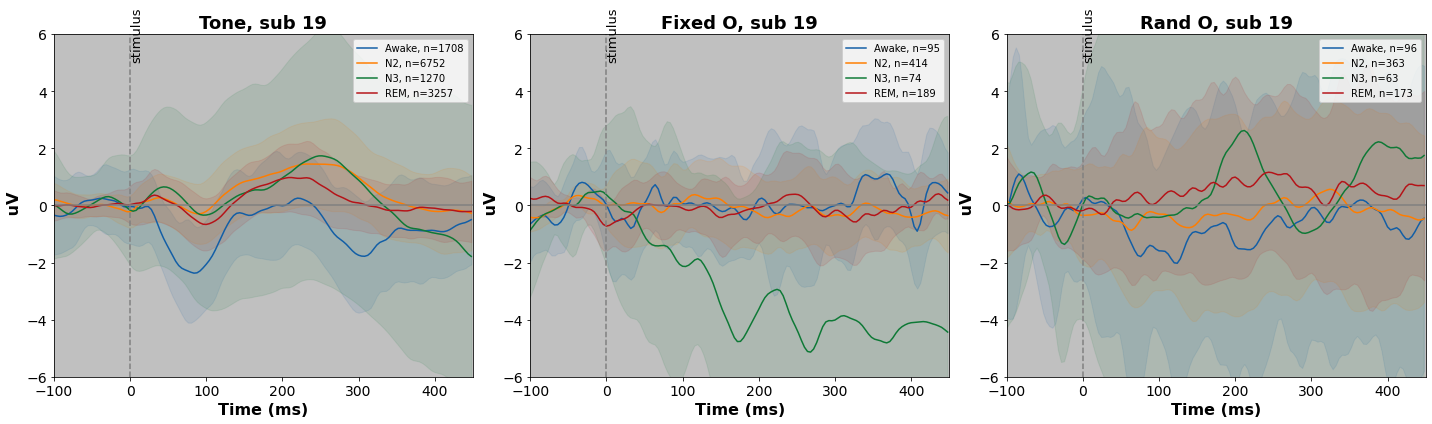

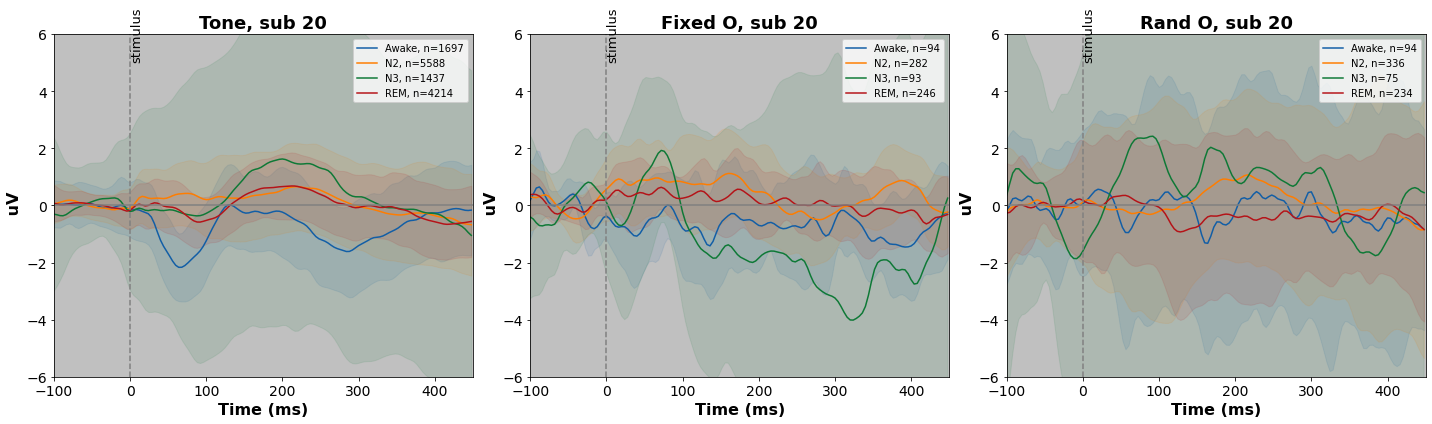

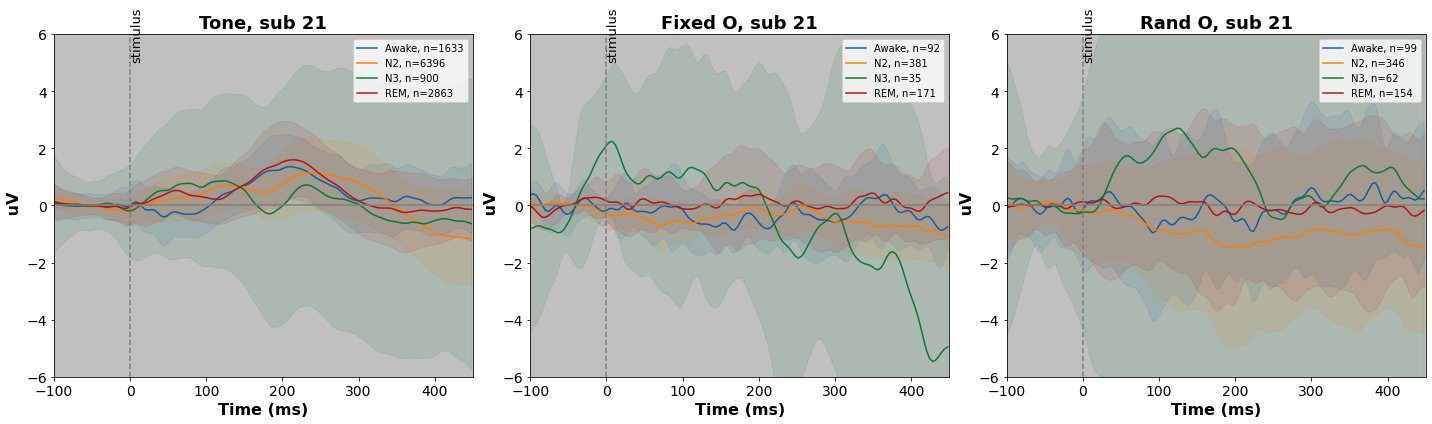

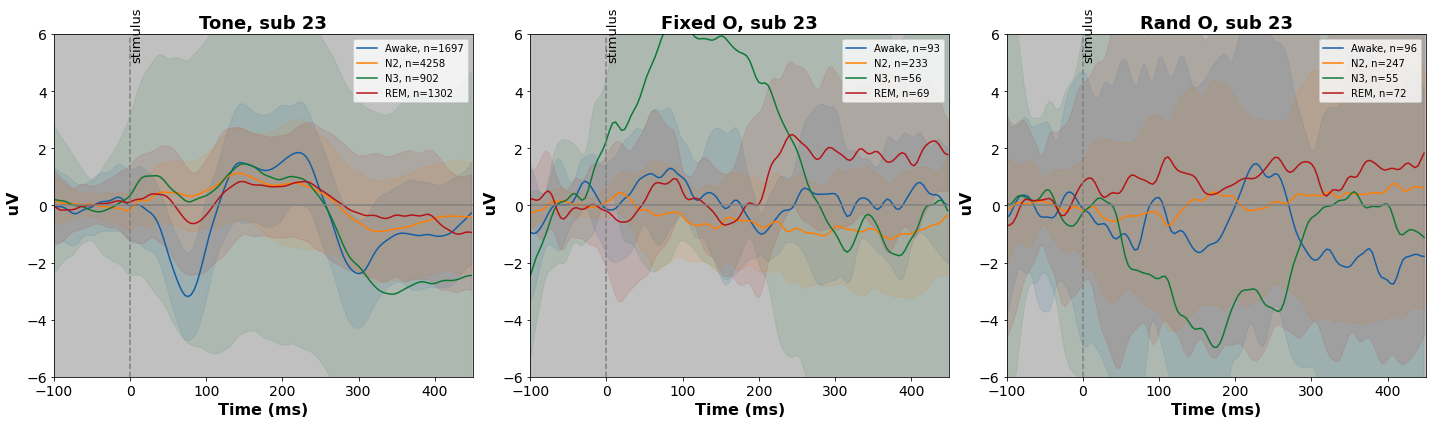

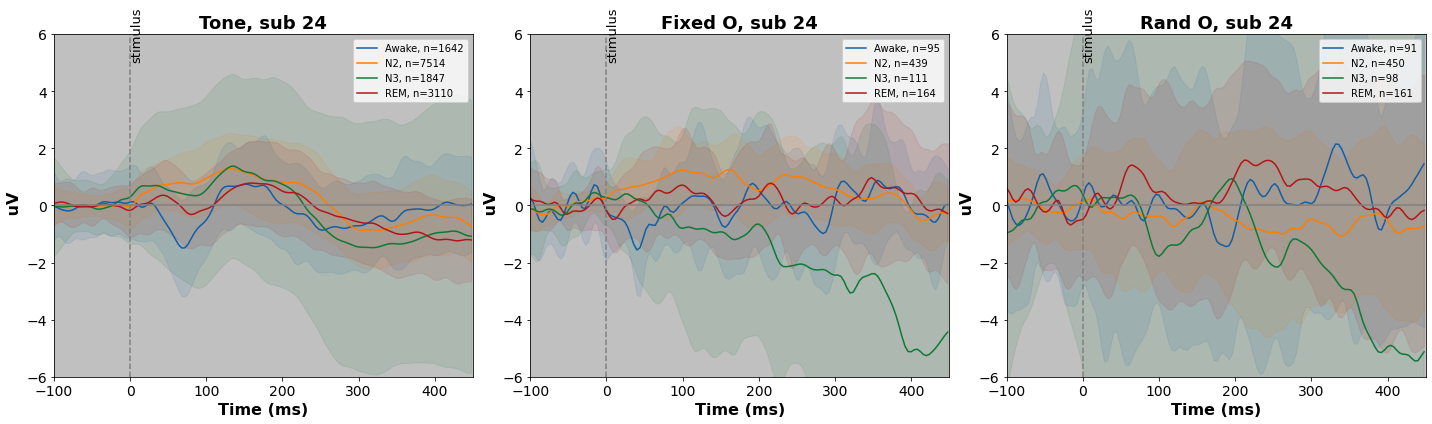

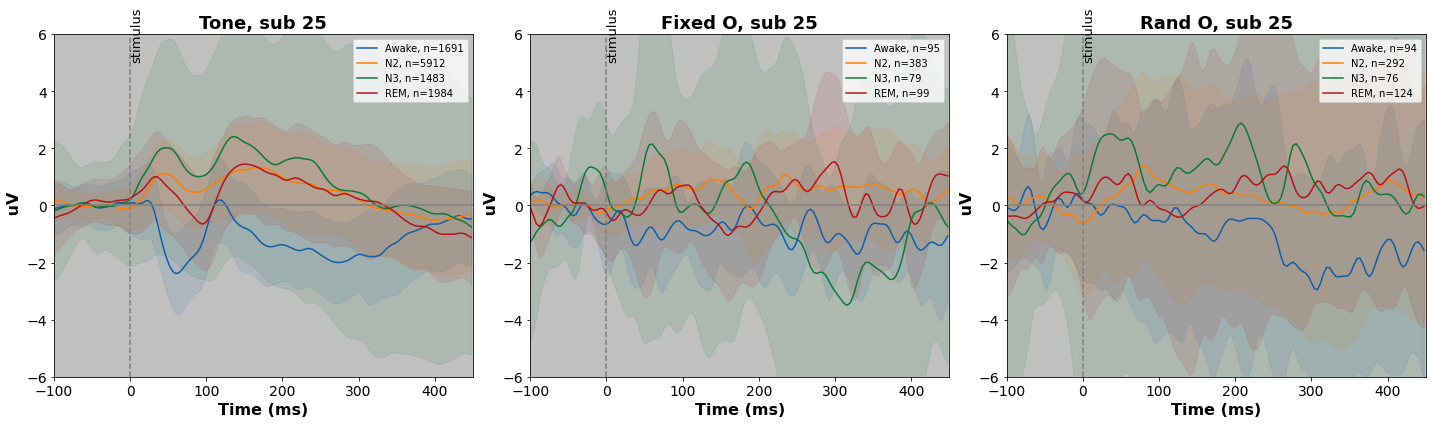

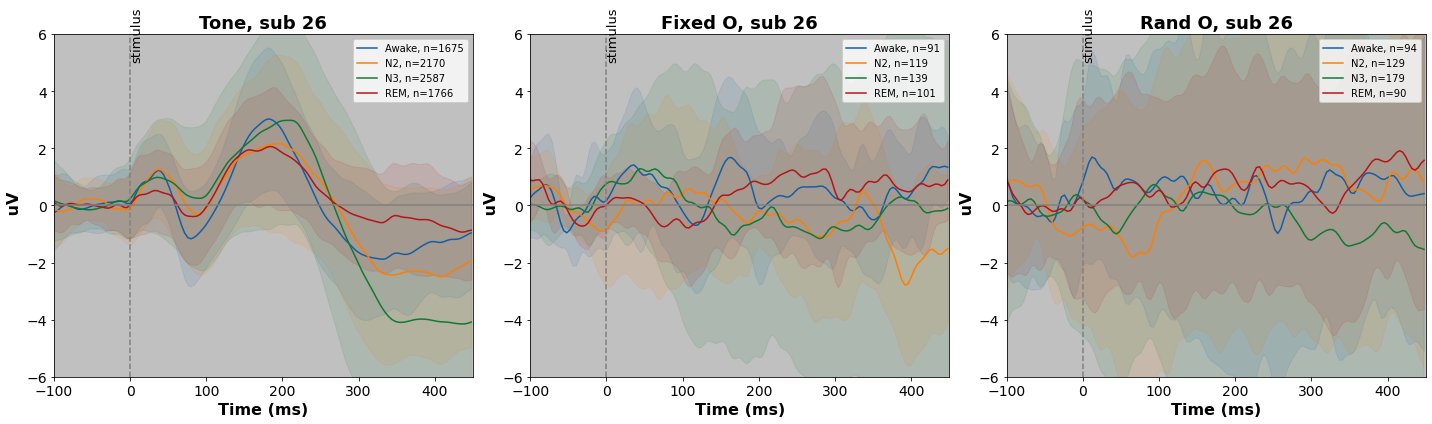

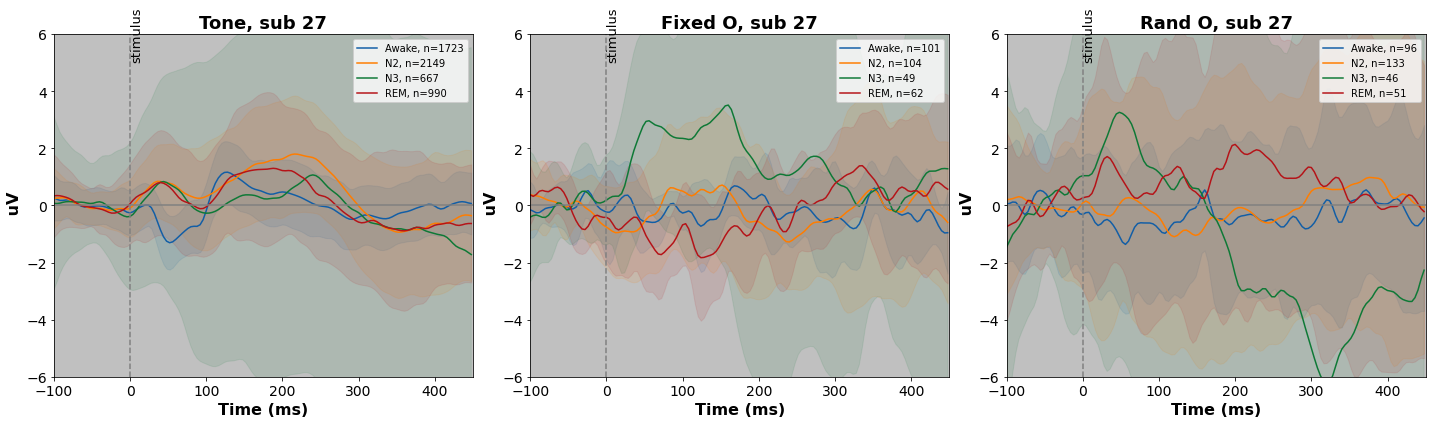

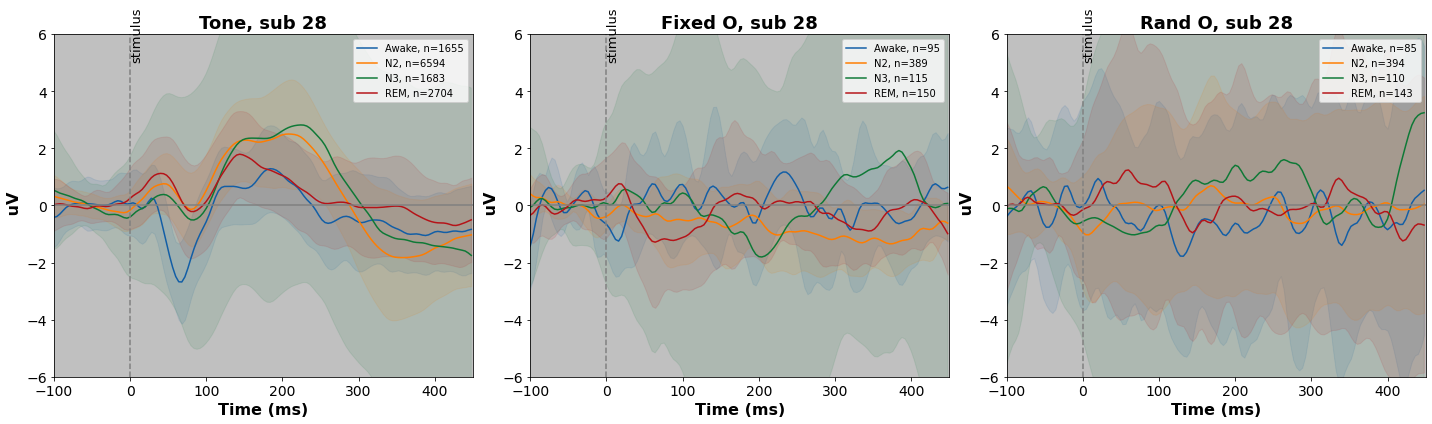

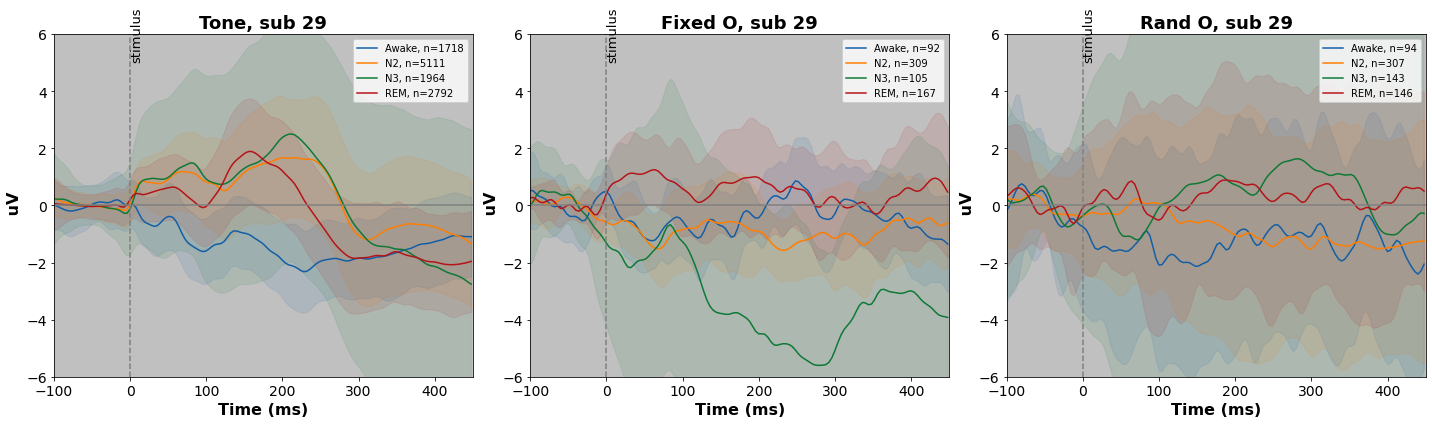

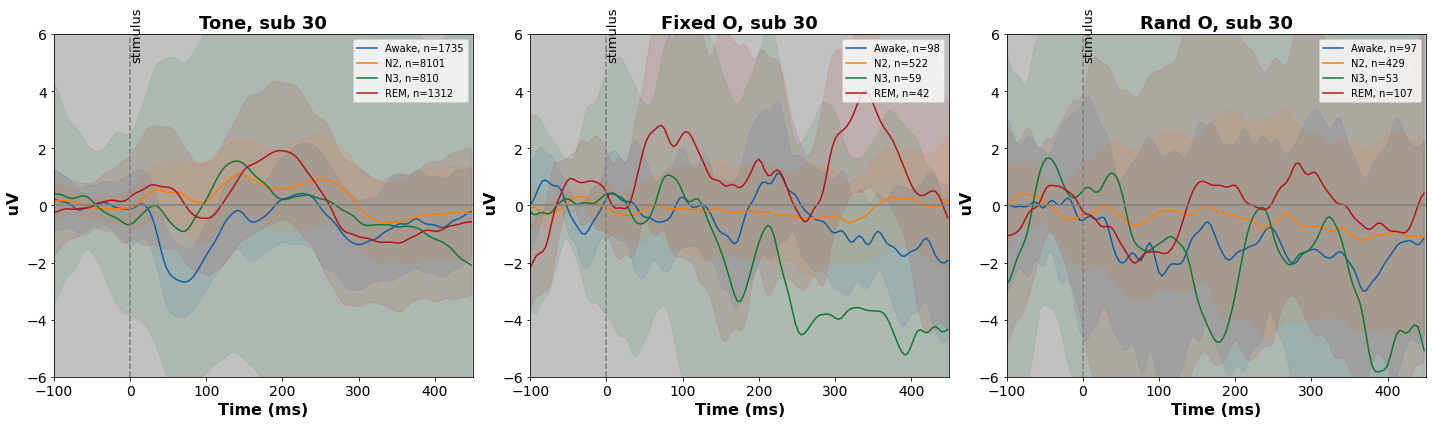

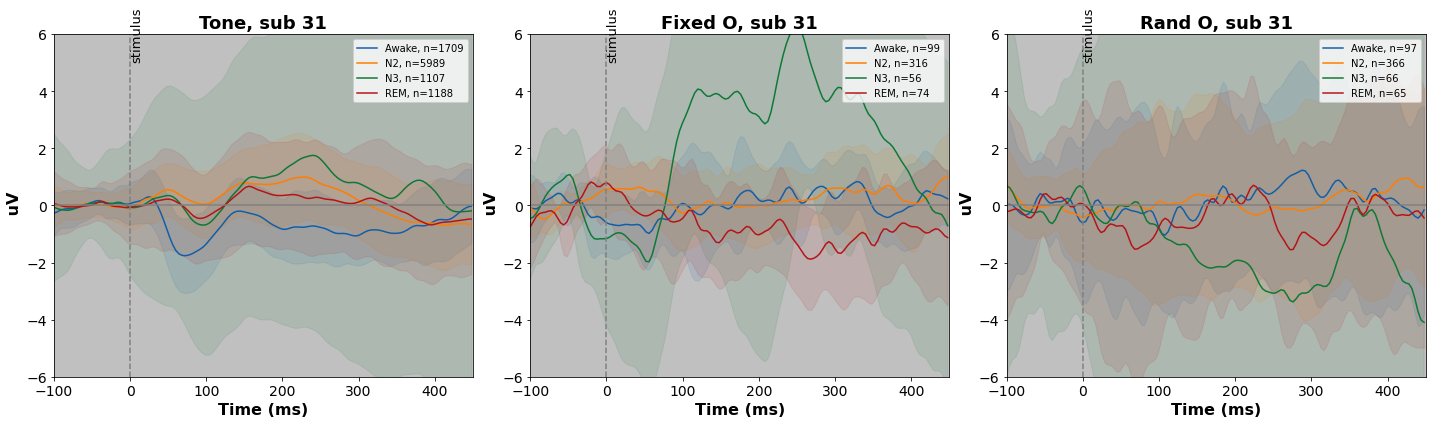

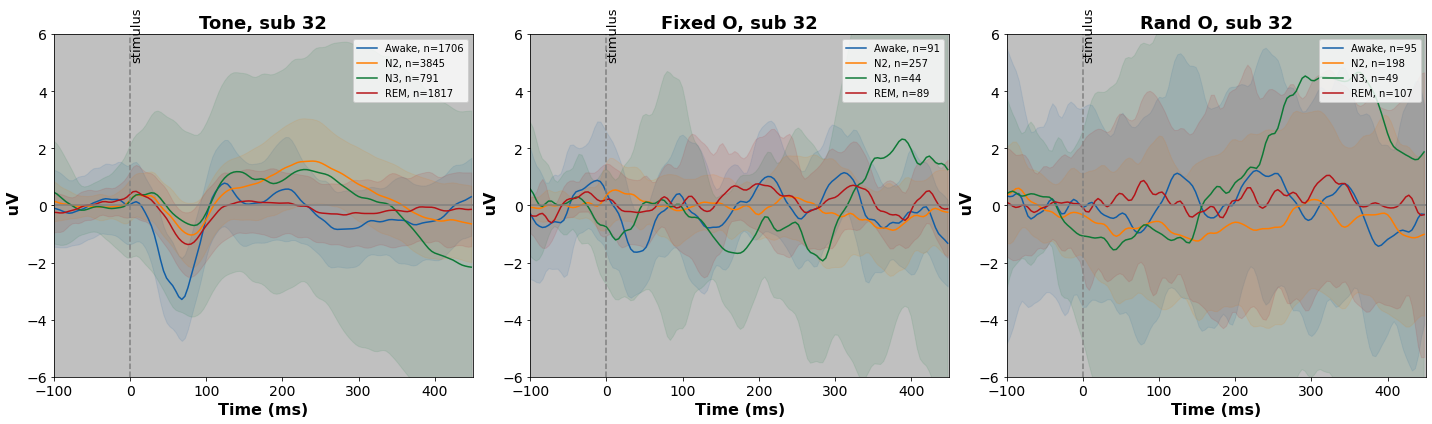

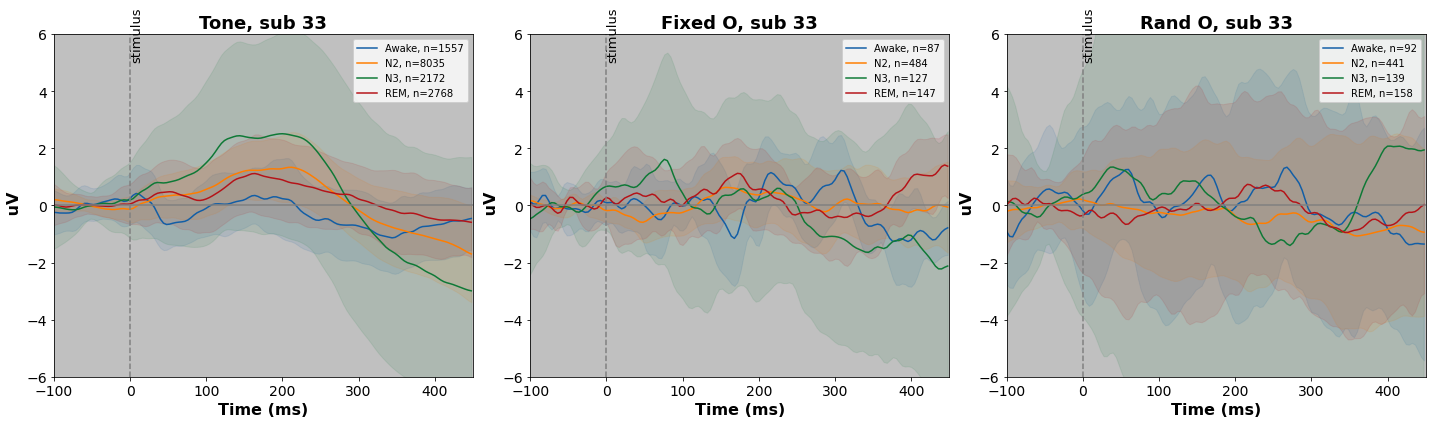

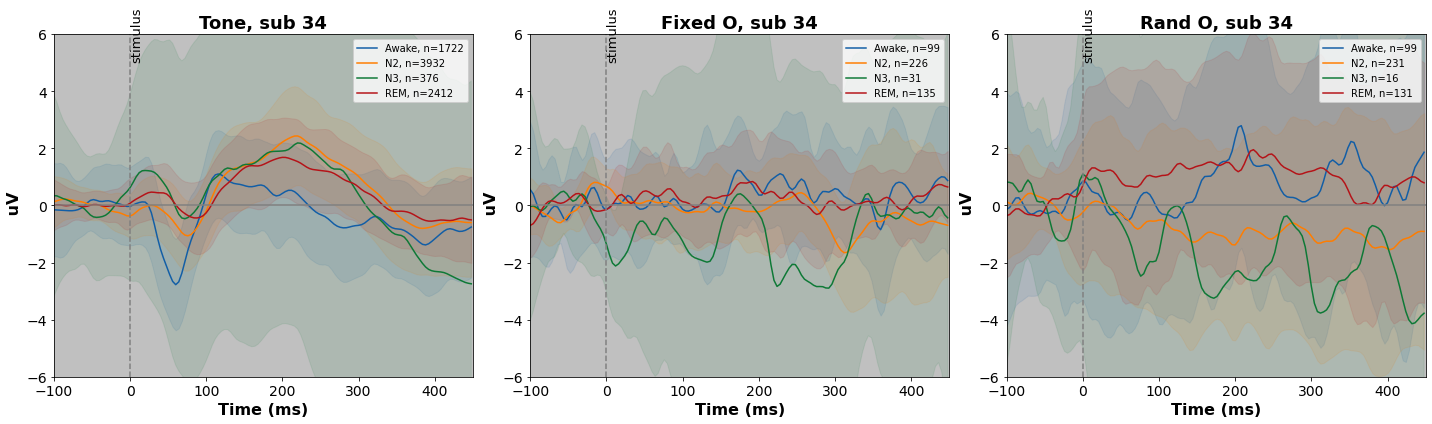

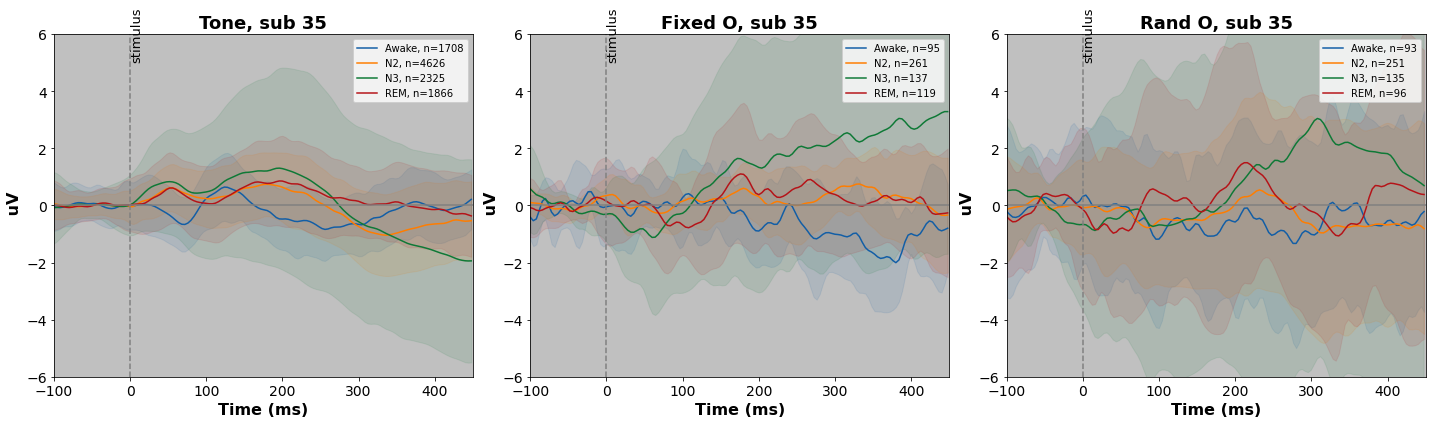

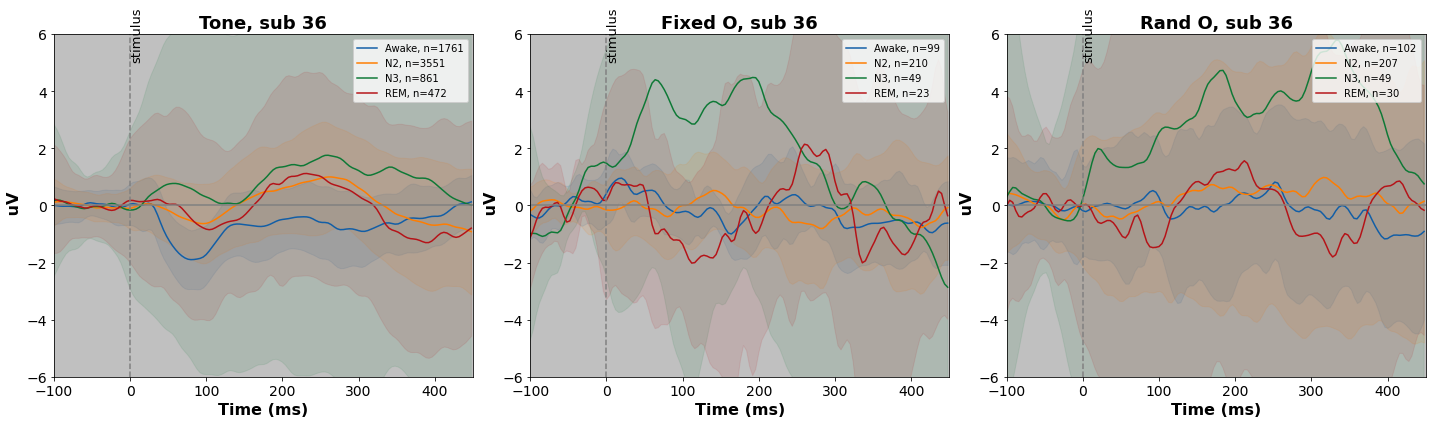

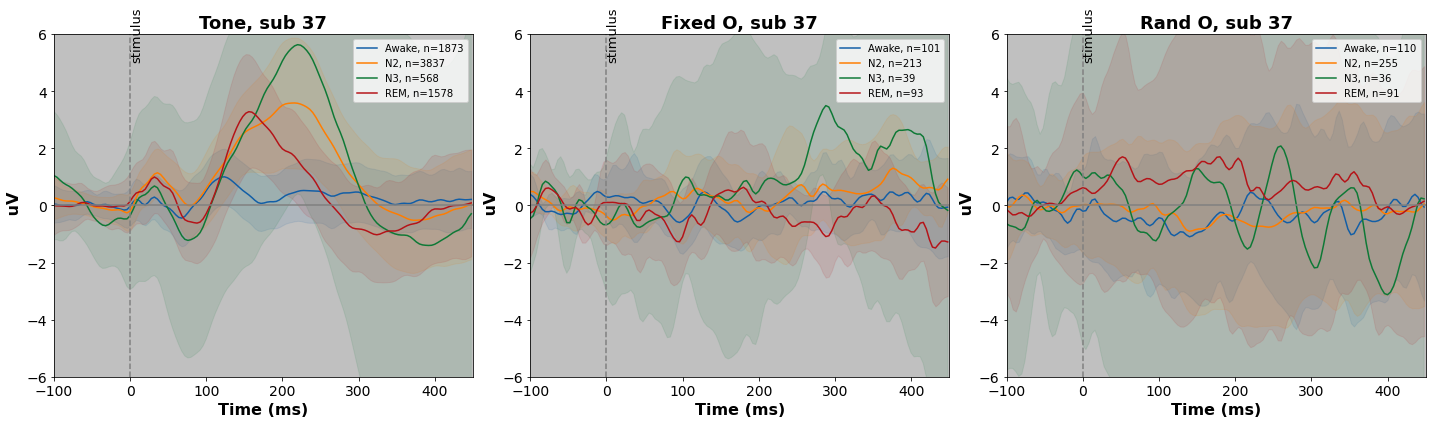

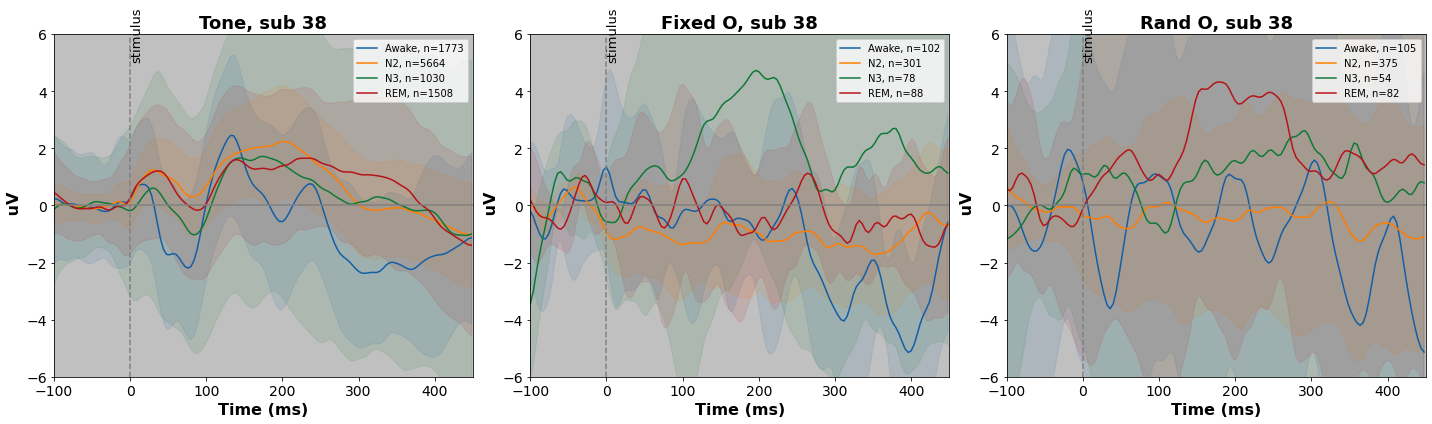

In [28]:
for sub in c['subs']:
    fig, axs = plt.subplots(1, 3,sharex=True, sharey=False,figsize = (20,6))

    constraints = {'TOA_cond':'T','Subject':sub}
    plot_erps_with_std('Vigilance','Cond_id', constraints, axs[0],colors_onePerVg,titles_onePerVg)
    plot_title = f'Tone, sub {sub}'
    applyDesign(axs[0],plot_title,y_lims=[-6,6])

    constraints = {'TOA_cond':'Fixed','Subject':sub}
    plot_erps_with_std('Vigilance','Cond_id', constraints, axs[1],colors_onePerVg,titles_onePerVg)
    plot_title = f'Fixed O, sub {sub}'
    applyDesign(axs[1],plot_title,y_lims=[-6,6])

    constraints = {'TOA_cond':'Rand','Subject':sub}
    plot_erps_with_std('Vigilance','Cond_id', constraints, axs[2],colors_onePerVg,titles_onePerVg)
    plot_title = f'Rand O, sub {sub}'
    applyDesign(axs[2],plot_title,y_lims=[-6,6])

    plt.tight_layout()
    plt.savefig(f'{fig_output_dir}/TOA_sub{sub}_5CentElect.png')
    plt.show()


### Same, but without std

# for sub in cfg['subs']:
#     fig, axs = plt.subplots(1, 3,sharex=True, sharey=False,figsize = (13,3))
#
#     constraints = {'TOA_cond':'T','Subject':sub}
#     plot_erps('Vigilance', constraints, axs[0],colors_onePerVg,titles_onePerVg)
#     plot_title = f'Tone, sub {sub}'
#     applyDesign(axs[0],plot_title,y_lims=[-6,6])
#
#     constraints = {'TOA_cond':'Fixed','Subject':sub}
#     plot_erps('Vigilance', constraints, axs[1],colors_onePerVg,titles_onePerVg)
#     plot_title = f'Fixed O, sub {sub}'
#     applyDesign(axs[1],plot_title,y_lims=[-6,6])
#
#     constraints = {'TOA_cond':'Rand','Subject':sub}
#     plot_erps('Vigilance', constraints, axs[2],colors_onePerVg,titles_onePerVg)
#     plot_title = f'Rand O, sub {sub}'
#     applyDesign(axs[2],plot_title,y_lims=[-6,6])
#
#     plt.tight_layout()
#     plt.show()

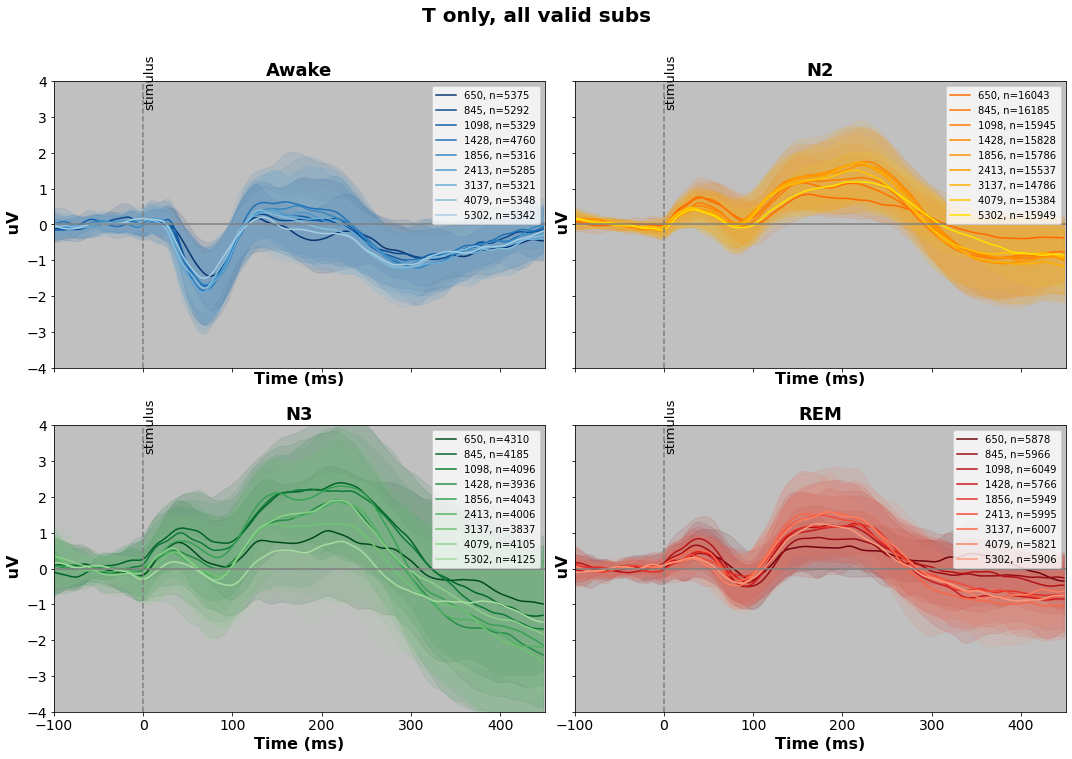

In [29]:
fig, axs = plt.subplots(2, len(c['vigi_states'])//2,sharex=True, sharey=True,figsize = (15,10))
axs = np.reshape(axs,[len(c['vigi_states'])])
for vg_i, vg in enumerate(c['vigi_states']):
    colors_pallte=colors_allShadesPerVg[vg_i]
    plot_erps_with_std('ToneHeight','Subject', {'TOA_cond':'T','Vigilance':vg}, axs[vg_i],colors_pallte,c['toneHeights'])
    plot_title = f"{titles_onePerVg[vg_i]}"
    applyDesign(axs[vg_i],plot_title)
plt.tight_layout()
plt.suptitle('T only, all valid subs', x = 0.5, y = 1.05, fontsize=20, weight='bold')
plt.ioff()
plt.savefig(f'{fig_output_dir}/T_perVigi_perToneH_allValidSubs_5CentElect.png')
plt.show()

## Omissions: Number of trials per vigi state

In [30]:
df_omission = pd.DataFrame({}, columns=['Subject', 'Vigilance', 'SamplesCount_rand','SamplesCount_fixed', 'Cond_id_rand','Cond_id_fixed'])
df_partly_filtered_fixed =  allEvents_df[(allEvents_df.TOA_cond == 'Fixed')]
df_partly_filtered_rand =   allEvents_df[(allEvents_df.TOA_cond == 'Rand')]

for sub_i, sub in enumerate(c['subs']):
    for vs_i, vs in enumerate(c['vigi_states']):
        curr_sub_vs_df_fixed = df_partly_filtered_fixed[(df_partly_filtered_fixed.Vigilance == vs) & (df_partly_filtered_fixed.Subject == sub)]
        curr_sub_vs_df_rand = df_partly_filtered_rand[(df_partly_filtered_rand.Vigilance == vs) & (df_partly_filtered_rand.Subject == sub)]

        df_temp = pd.DataFrame({
                    "Subject":[sub],
                    "Vigilance":[vs],
                    'SamplesCount_rand':[np.sum(curr_sub_vs_df_rand.SamplesCount)],
                    'SamplesCount_fixed':[np.sum(curr_sub_vs_df_fixed.SamplesCount)],
                    'Cond_id_rand':[np.array(curr_sub_vs_df_rand.Cond_id)],
                    'Cond_id_fixed':[np.array(curr_sub_vs_df_fixed.Cond_id)]})
        df_omission = pd.concat((df_omission, df_temp),ignore_index=True)

df_lessThan30Trials = df_omission[(df_omission.SamplesCount_rand < 30) | (df_omission.SamplesCount_fixed < 30)]
df_lessThan30Trials.to_excel(f'{fig_output_dir}/df_omission_lessThan30Trials.xlsx')
df_omission.to_excel(f"{fig_output_dir}/df_omission_all.xlsx")
display(df_lessThan30Trials)
# df_omission_subs = df_omission[(df_omission.Subject == '12') | (df_omission.Subject == '17') |(df_omission.Subject == '34')]
# df_omission_subs

Subject Vigilance SamplesCount_rand SamplesCount_fixed  \
22       14        N3                13                 22   
23       14       REM                16                 12   
34       17        N3                25                 36   
94       34        N3                16                 31   
103      36       REM                30                 23   

                                          Cond_id_rand  \
22   [6035, 6036, 6037, 6038, 6045, 6046, 6047, 604...   
23   [6305, 6306, 6307, 6308, 6315, 6316, 6317, 631...   
34   [9275, 9276, 9277, 9278, 9285, 9286, 9287, 928...   
94   [25475, 25476, 25477, 25478, 25485, 25486, 254...   
103  [27905, 27906, 27907, 27908, 27915, 27916, 279...   

                                         Cond_id_fixed  
22   [6039, 6049, 6059, 6069, 6079, 6089, 6099, 610...  
23   [6309, 6319, 6329, 6339, 6349, 6359, 6369, 637...  
34   [9279, 9289, 9299, 9309, 9319, 9329, 9339, 934...  
94   [25479, 25489, 25499, 25509, 25519, 25529, 255...  
103  [27909, 27919, 27929, 27939, 27949, 27959, 279...

## Omissions vs Tone: Number of trials per vigi state

In [31]:
df_omission_vs_tone = pd.DataFrame({}, columns=['Subject', 'Vigilance', 'SamplesCount_omis','SamplesCount_tone', 'SamplesCount_ratio','Cond_id_omis','Cond_id_tone'])
df_partly_filtered_omis =  allEvents_df[(allEvents_df.TOA == 'O')]
df_partly_filtered_tone =  allEvents_df[(allEvents_df.TOA == 'T') ]

for sub_i, sub in enumerate(c['subs']):
    for vs_i, vs in enumerate(c['vigi_states']):
        curr_sub_vs_df_omis = df_partly_filtered_omis[(df_partly_filtered_omis.Vigilance == vs) & (df_partly_filtered_omis.Subject == sub)]
        curr_sub_vs_df_tone = df_partly_filtered_tone[(df_partly_filtered_tone.Vigilance == vs) & (df_partly_filtered_tone.Subject == sub)]


        df_temp = pd.DataFrame({
                    "Subject":[sub],
                    "Vigilance":[vs],
                    'SamplesCount_omis':[np.sum(curr_sub_vs_df_omis.SamplesCount)],
                    'SamplesCount_tone':[np.sum(curr_sub_vs_df_tone.SamplesCount)],
                    'SamplesCount_ratio':[np.sum(curr_sub_vs_df_omis.SamplesCount)/np.sum(curr_sub_vs_df_tone.SamplesCount)],
                    'Cond_id_omis':[np.array(curr_sub_vs_df_omis.Cond_id)],
                    'Cond_id_tone':[np.array(curr_sub_vs_df_tone.Cond_id)]})
        df_omission_vs_tone = pd.concat((df_omission_vs_tone, df_temp),ignore_index=True)

df_omission_vs_tone.to_excel(f'{fig_output_dir}/df_omissionVStones_trialsRatio.xlsx')
df_omission_vs_tone

Subject Vigilance SamplesCount_omis SamplesCount_tone  SamplesCount_ratio  \
0        08        Wn               191              1684            0.113420   
1        08        N2               544              4650            0.116989   
2        08        N3               161              1462            0.110123   
3        08       REM               126              1113            0.113208   
4        09        Wn               196              1753            0.111808   
..      ...       ...               ...               ...                 ...   
107      37       REM               184              1578            0.116603   
108      38        Wn               207              1773            0.116751   
109      38        N2               676              5664            0.119350   
110      38        N3               132              1030            0.128155   
111      38       REM               170              1508            0.112732   

                                          Cond_id_omis  \
0    [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...   
1    [360, 361, 362, 363, 364, 365, 366, 367, 368, ...   
2    [630, 631, 632, 633, 634, 635, 636, 637, 638, ...   
3    [900, 901, 902, 903, 904, 905, 906, 907, 908, ...   
4    [1170, 1171, 1172, 1173, 1174, 1175, 1176, 117...   
..                                                 ...   
107  [28980, 28981, 28982, 28983, 28984, 28985, 289...   
108  [29250, 29251, 29252, 29253, 29254, 29255, 292...   
109  [29520, 29521, 29522, 29523, 29524, 29525, 295...   
110  [29790, 29791, 29792, 29793, 29794, 29795, 297...   
111  [30060, 30061, 30062, 30063, 30064, 30065, 300...   

                                          Cond_id_tone  
0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1    [270, 271, 272, 273, 274, 275, 276, 277, 278, ...  
2    [540, 541, 542, 543, 544, 545, 546, 547, 548, ...  
3    [810, 811, 812, 813, 814, 815, 816, 817, 818, ...  
4    [1080, 1081, 1082, 1083, 1084, 1085, 1086, 108...  
..                                                 ...  
107  [28890, 28891, 28892, 28893, 28894, 28895, 288...  
108  [29160, 29161, 29162, 29163, 29164, 29165, 291...  
109  [29430, 29431, 29432, 29433, 29434, 29435, 294...  
110  [29700, 29701, 29702, 29703, 29704, 29705, 297...  
111  [29970, 29971, 29972, 29973, 29974, 29975, 299...  

[112 rows x 7 columns]

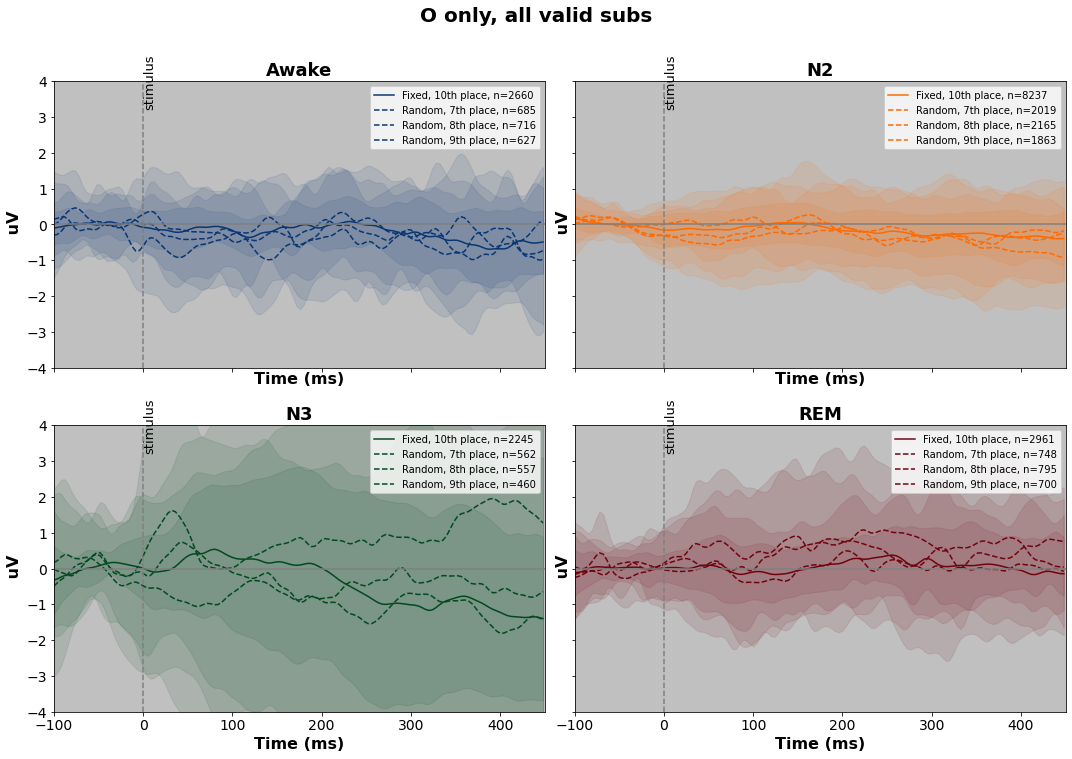

In [32]:
## initial filter full dataframe
curr_df = allEvents_df[(allEvents_df.TOA == 'O') & (allEvents_df.TrialPosition > '4')]
curr_subs = curr_df.Subject.unique()
curr_vss = curr_df.Vigilance.unique()

conds_names = [['Fixed, 10th place'], ['Random, 7th place'],['Random, 8th place'],['Random, 9th place']]
conds_linestyles =['-', '--','--','--']

constraints = [{"TOA_cond": "Fixed"},
               {"TOA_cond": "Rand","TrialPosition" : "6"},
               {"TOA_cond": "Rand","TrialPosition" : "7"},
               {"TOA_cond": "Rand","TrialPosition" : "8"},]

fig, axs = plt.subplots(2, len(c['vigi_states'])//2,sharex=True, sharey=True,figsize = (15,10))
axs = np.reshape(axs,[len(c['vigi_states'])])
for vg_i, vg in enumerate(c['vigi_states']):
    colors_pallte=colors_allShadesPerVg[vg_i]
    for const_i ,constraint in enumerate(constraints):
        curr_constr = constraint.copy()
        curr_constr['Vigilance']=vg
        plot_erps_with_std("TOA_cond",'Subject', curr_constr, axs[vg_i],colors_allShadesPerVg[vg_i],conds_names[const_i], varsForMean=[constraint["TOA_cond"]],linestyle=conds_linestyles[const_i])

    plot_title = f"{titles_onePerVg[vg_i]}"
    applyDesign(axs[vg_i],plot_title)
plt.tight_layout()
plt.suptitle('O only, all valid subs', x = 0.5, y = 1.05, fontsize=20, weight='bold')

plt.ioff()
plt.savefig(f'{fig_output_dir}/Omis_perVigi_perTrialPos_allValidSubs_5CentElect.png')
plt.show()